# Hierarchical Classification - Stage 2: Fine Pathology Training

This notebook trains **Stage 2 (Fine Classifiers)** of the hierarchical classification model.

## Prerequisites
- Run `03a_stage1_coarse_training.ipynb` first to train and save the coarse classifier

## Training Pipeline
- **Stage 1 (Previous Notebook)**: Pre-trained coarse classifier (anatomical regions)
- **Stage 2 (This Notebook)**: Load Stage 1 weights, train entire model **end-to-end**

## End-to-End Training (NO FREEZING)
Unlike traditional transfer learning where early layers are frozen, we train the entire model together. This allows the shared backbone to adapt its representations for the fine-grained pathology classification task.

## Fine Classifiers
- **Abdomen**: Organ classification
- **Chest**: Nodule and fracture classification
- **Brain**: Vessel classification

In [1]:
import sys
sys.path.insert(0, '..')

import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.hierarchical_model import HierarchicalClassificationModel

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


## 1. Load Stage 1 Configuration

In [2]:
# Load Stage 1 information
stage1_info_path = f"{PATHS['models']}/stage1_info_{MODEL_CONFIG['architecture']}.json"

if not os.path.exists(stage1_info_path):
    raise FileNotFoundError(
        f"Stage 1 info file not found at {stage1_info_path}. "
        "Please run 03a_stage1_coarse_training.ipynb first."
    )

with open(stage1_info_path, 'r') as f:
    stage1_info = json.load(f)

print("Stage 1 Information:")
print(f"  Model path: {stage1_info['model_path']}")
print(f"  Architecture: {stage1_info['architecture']}")
print(f"  Coarse Test Accuracy: {stage1_info['test_accuracy']:.4f}")
print(f"  Best Val Accuracy: {stage1_info['best_val_accuracy']:.4f}")

Stage 1 Information:
  Model path: /home/luca/HierarchicalMIC/models/stage1_coarse_enhanced.pth
  Architecture: enhanced
  Coarse Test Accuracy: 0.9467
  Best Val Accuracy: 0.9777


## 2. Load Merged Dataset

In [3]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Test samples: {dataset_info['test_samples']:,}")
print(f"\nCoarse classes (regions): {dataset_info['num_coarse_classes']}")
print(f"Region mapping: {dataset_info['idx_to_region']}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verif

In [4]:
# Configure region-specific classes
region_configs = dataset_info['region_num_classes']
region_idx_to_name = dataset_info['idx_to_region']

print("Region configurations:")
for region, num_classes in region_configs.items():
    print(f"  {region}: {num_classes} classes")

Region configurations:
  abdomen: 10 classes
  chest: 8 classes
  brain: 2 classes


## 3. Build and Load Hierarchical Model with Stage 1 Weights

In [5]:
# Create hierarchical model
model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    coarse_model_type=MODEL_CONFIG['coarse_architecture'],
    fine_model_type=MODEL_CONFIG['fine_architecture'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_idx_to_name=region_idx_to_name,
    num_total_organs=dataset_info['num_fine_classes'],
    use_subtypes=False
).to(DEVICE)

# Load Stage 1 weights
stage1_path = stage1_info['model_path']
if not os.path.exists(stage1_path):
    raise FileNotFoundError(
        f"Stage 1 model not found at {stage1_path}. "
        "Please run 03a_stage1_coarse_training.ipynb first."
    )

model.load_state_dict(torch.load(stage1_path))
print(f"\nLoaded Stage 1 weights from: {stage1_path}")


Loaded Stage 1 weights from: /home/luca/HierarchicalMIC/models/stage1_coarse_enhanced.pth


/tmp/ipykernel_20387/1499373810.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(stage1_path))


In [6]:
# End-to-End Training: All parameters are trainable!
print("\nEnd-to-End Training Mode (NO FREEZING)")
print("Both Stage 1 (Coarse) and Stage 2 (Fine) classifiers will be trained together.")

# Count parameters - all should be trainable
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel configuration:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Coarse architecture: {MODEL_CONFIG['coarse_architecture']}")
print(f"  Fine architecture: {MODEL_CONFIG['fine_architecture']}")


End-to-End Training Mode (NO FREEZING)
Both Stage 1 (Coarse) and Stage 2 (Fine) classifiers will be trained together.

Model configuration:
  Total parameters: 8,375,191
  Trainable parameters: 8,375,191
  Coarse architecture: enhanced
  Fine architecture: enhanced


## 4. End-to-End Training: Coarse + Fine Classifiers

This stage trains the entire hierarchical model end-to-end. Both the coarse classifier (from Stage 1) and the fine classifiers are trained together, allowing the shared backbone to adapt for the fine-grained pathology task.

In [7]:
def train_stage2(model, train_loader, val_loader, device, epochs, lr, region_idx_to_name):
    """Train entire hierarchical model end-to-end (no freezing)."""
    
    criterion = nn.CrossEntropyLoss()
    
    # Optimize ALL model parameters (end-to-end training)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'coarse_train_acc': [],
        'coarse_val_acc': [],
        'region_train_acc': {name: [] for name in region_idx_to_name.values()},
        'region_val_acc': {name: [] for name in region_idx_to_name.values()}
    }
    
    best_val_acc = 0.0
    
    print("\n=== End-to-End Training: Coarse + Fine Classifiers ===")
    print("(All parameters are trainable)\n")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Tracking for coarse accuracy
        coarse_correct = 0
        coarse_total = 0
        
        region_correct = {name: 0 for name in region_idx_to_name.values()}
        region_total = {name: 0 for name in region_idx_to_name.values()}
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for imgs, coarse_labels, fine_labels in pbar:
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            coarse_labels = coarse_labels.long().to(device)
            fine_labels = fine_labels.long().to(device)
            
            optimizer.zero_grad()
            batch_loss = 0.0
            
            # Also train coarse classifier (end-to-end)
            coarse_logits = model.forward_coarse(imgs)
            coarse_loss = criterion(coarse_logits, coarse_labels)
            batch_loss = batch_loss + coarse_loss
            
            # Track coarse accuracy
            coarse_preds = coarse_logits.argmax(1)
            coarse_correct += (coarse_preds == coarse_labels).sum().item()
            coarse_total += imgs.size(0)
            
            # Train each region's fine classifier
            for region_idx, region_name in region_idx_to_name.items():
                mask = (coarse_labels == region_idx)
                if not mask.any():
                    continue
                
                region_imgs = imgs[mask]
                region_fine_labels = fine_labels[mask]
                
                fine_logits = model.forward_fine(region_imgs, region_name)
                loss = criterion(fine_logits, region_fine_labels)
                batch_loss = batch_loss + loss
                
                preds = fine_logits.argmax(1)
                region_correct[region_name] += (preds == region_fine_labels).sum().item()
                region_total[region_name] += region_imgs.size(0)
            
            if isinstance(batch_loss, float) and batch_loss == 0.0:
                continue
            
            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss.item()
        
        # Compute training metrics
        avg_train_loss = train_loss / len(train_loader)
        total_correct = sum(region_correct.values())
        total_samples = sum(region_total.values())
        train_acc = total_correct / total_samples if total_samples > 0 else 0
        coarse_train_acc = coarse_correct / coarse_total if coarse_total > 0 else 0
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['coarse_train_acc'].append(coarse_train_acc)
        
        for region_name in region_idx_to_name.values():
            if region_total[region_name] > 0:
                acc = region_correct[region_name] / region_total[region_name]
            else:
                acc = 0.0
            history['region_train_acc'][region_name].append(acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_coarse_correct = 0
        val_coarse_total = 0
        val_region_correct = {name: 0 for name in region_idx_to_name.values()}
        val_region_total = {name: 0 for name in region_idx_to_name.values()}
        
        with torch.no_grad():
            for imgs, coarse_labels, fine_labels in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                if imgs.max() > 1:
                    imgs = imgs / 255.0
                coarse_labels = coarse_labels.long().to(device)
                fine_labels = fine_labels.long().to(device)
                
                # Coarse validation
                coarse_logits = model.forward_coarse(imgs)
                coarse_loss = criterion(coarse_logits, coarse_labels)
                val_loss += coarse_loss.item()
                
                coarse_preds = coarse_logits.argmax(1)
                val_coarse_correct += (coarse_preds == coarse_labels).sum().item()
                val_coarse_total += imgs.size(0)
                
                # Fine validation per region
                for region_idx, region_name in region_idx_to_name.items():
                    mask = (coarse_labels == region_idx)
                    if not mask.any():
                        continue
                    
                    region_imgs = imgs[mask]
                    region_fine_labels = fine_labels[mask]
                    
                    fine_logits = model.forward_fine(region_imgs, region_name)
                    loss = criterion(fine_logits, region_fine_labels)
                    val_loss += loss.item()
                    
                    preds = fine_logits.argmax(1)
                    val_region_correct[region_name] += (preds == region_fine_labels).sum().item()
                    val_region_total[region_name] += region_imgs.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        val_total_correct = sum(val_region_correct.values())
        val_total_samples = sum(val_region_total.values())
        val_acc = val_total_correct / val_total_samples if val_total_samples > 0 else 0
        val_coarse_acc = val_coarse_correct / val_coarse_total if val_coarse_total > 0 else 0
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['coarse_val_acc'].append(val_coarse_acc)
        
        for region_name in region_idx_to_name.values():
            if val_region_total[region_name] > 0:
                acc = val_region_correct[region_name] / val_region_total[region_name]
            else:
                acc = 0.0
            history['region_val_acc'][region_name].append(acc)
        
        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1} Results:")
        print(f"  Coarse: Train Acc={coarse_train_acc:.4f}, Val Acc={val_coarse_acc:.4f}")
        for region_name in region_idx_to_name.values():
            train_r_acc = history['region_train_acc'][region_name][-1]
            val_r_acc = history['region_val_acc'][region_name][-1]
            print(f"  {region_name}: Train Acc={train_r_acc:.4f}, Val Acc={val_r_acc:.4f}")
        print(f"  Overall: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 
                       f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth")
            print(f"  -> New best model saved (Val Acc: {best_val_acc:.4f})")
        print()
    
    print(f"\nEnd-to-End Training Complete! Best Val Acc: {best_val_acc:.4f}")
    return history, best_val_acc

In [8]:
# Training configuration
print(f"Training configuration:")
print(f"  Fine epochs: {TRAINING_CONFIG['fine_epochs']}")
print(f"  Learning rate: {TRAINING_CONFIG['learning_rate']}")

Training configuration:
  Fine epochs: 30
  Learning rate: 0.001


In [9]:

# Train Stage 2 (End-to-End)
history, best_val_acc = train_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=TRAINING_CONFIG['fine_epochs'],
    lr=TRAINING_CONFIG['learning_rate'],
    region_idx_to_name=region_idx_to_name
)

print("\n" + "="*60)
print("STAGE 2 END-TO-END TRAINING COMPLETE!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Full model saved to: {PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth")

/home/luca/.pyenv/versions/3.12.11/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== End-to-End Training: Coarse + Fine Classifiers ===
(All parameters are trainable)



Epoch 1: 100%|██████████| 710/710 [00:57<00:00, 12.31it/s]


Epoch 1 Results:
  Coarse: Train Acc=0.9574, Val Acc=0.9763
  abdomen: Train Acc=0.5075, Val Acc=0.4201
  chest: Train Acc=0.4881, Val Acc=0.5260
  brain: Train Acc=0.8816, Val Acc=0.8848
  Overall: Train Loss=3.0249, Train Acc=0.5874, Val Loss=1.5522, Val Acc=0.5891
  -> New best model saved (Val Acc: 0.5891)



Epoch 2: 100%|██████████| 710/710 [00:57<00:00, 12.34it/s]


Epoch 2 Results:
  Coarse: Train Acc=0.9665, Val Acc=0.9680
  abdomen: Train Acc=0.5231, Val Acc=0.5297
  chest: Train Acc=0.5493, Val Acc=0.5487
  brain: Train Acc=0.8869, Val Acc=0.8848
  Overall: Train Loss=2.6058, Train Acc=0.6195, Val Loss=1.3177, Val Acc=0.6323
  -> New best model saved (Val Acc: 0.6323)



Epoch 3: 100%|██████████| 710/710 [00:57<00:00, 12.35it/s]


Epoch 3 Results:
  Coarse: Train Acc=0.9595, Val Acc=0.9638
  abdomen: Train Acc=0.5382, Val Acc=0.4521
  chest: Train Acc=0.5743, Val Acc=0.6169
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.4964, Train Acc=0.6353, Val Loss=1.1690, Val Acc=0.6379
  -> New best model saved (Val Acc: 0.6379)



Epoch 4: 100%|██████████| 710/710 [00:57<00:00, 12.40it/s]


Epoch 4 Results:
  Coarse: Train Acc=0.9625, Val Acc=0.9777
  abdomen: Train Acc=0.5754, Val Acc=0.5708
  chest: Train Acc=0.5794, Val Acc=0.5682
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.3727, Train Acc=0.6505, Val Loss=2.2001, Val Acc=0.6532
  -> New best model saved (Val Acc: 0.6532)



Epoch 5: 100%|██████████| 710/710 [00:57<00:00, 12.34it/s]


Epoch 5 Results:
  Coarse: Train Acc=0.9687, Val Acc=0.9624
  abdomen: Train Acc=0.5799, Val Acc=0.5571
  chest: Train Acc=0.5964, Val Acc=0.3571
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.3262, Train Acc=0.6591, Val Loss=1.6037, Val Acc=0.5585



Epoch 6: 100%|██████████| 710/710 [00:57<00:00, 12.36it/s]


Epoch 6 Results:
  Coarse: Train Acc=0.9574, Val Acc=0.9735
  abdomen: Train Acc=0.6000, Val Acc=0.5890
  chest: Train Acc=0.6007, Val Acc=0.6104
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.2387, Train Acc=0.6679, Val Loss=1.0648, Val Acc=0.6769
  -> New best model saved (Val Acc: 0.6769)



Epoch 7: 100%|██████████| 710/710 [00:57<00:00, 12.37it/s]


Epoch 7 Results:
  Coarse: Train Acc=0.9632, Val Acc=0.9596
  abdomen: Train Acc=0.6040, Val Acc=0.5662
  chest: Train Acc=0.6143, Val Acc=0.6461
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.1686, Train Acc=0.6749, Val Loss=1.0394, Val Acc=0.6852
  -> New best model saved (Val Acc: 0.6852)



Epoch 8: 100%|██████████| 710/710 [00:57<00:00, 12.34it/s]


Epoch 8 Results:
  Coarse: Train Acc=0.9653, Val Acc=0.9777
  abdomen: Train Acc=0.6221, Val Acc=0.6667
  chest: Train Acc=0.6270, Val Acc=0.6299
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.1081, Train Acc=0.6866, Val Loss=0.9695, Val Acc=0.7089
  -> New best model saved (Val Acc: 0.7089)



Epoch 9: 100%|██████████| 710/710 [00:57<00:00, 12.41it/s]


Epoch 9 Results:
  Coarse: Train Acc=0.9667, Val Acc=0.9721
  abdomen: Train Acc=0.6432, Val Acc=0.5982
  chest: Train Acc=0.6185, Val Acc=0.6753
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.0527, Train Acc=0.6904, Val Loss=0.9249, Val Acc=0.7075



Epoch 10: 100%|██████████| 710/710 [00:57<00:00, 12.35it/s]


Epoch 10 Results:
  Coarse: Train Acc=0.9665, Val Acc=0.9694
  abdomen: Train Acc=0.6543, Val Acc=0.6530
  chest: Train Acc=0.6287, Val Acc=0.6721
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=2.0375, Train Acc=0.6985, Val Loss=0.8809, Val Acc=0.7228
  -> New best model saved (Val Acc: 0.7228)



Epoch 11: 100%|██████████| 710/710 [00:57<00:00, 12.40it/s]


Epoch 11 Results:
  Coarse: Train Acc=0.9697, Val Acc=0.9805
  abdomen: Train Acc=0.6628, Val Acc=0.7260
  chest: Train Acc=0.6359, Val Acc=0.6753
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=1.9747, Train Acc=0.7045, Val Loss=0.7803, Val Acc=0.7465
  -> New best model saved (Val Acc: 0.7465)



Epoch 12: 100%|██████████| 710/710 [00:57<00:00, 12.35it/s]


Epoch 12 Results:
  Coarse: Train Acc=0.9709, Val Acc=0.9763
  abdomen: Train Acc=0.6799, Val Acc=0.6941
  chest: Train Acc=0.6478, Val Acc=0.6526
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=1.9269, Train Acc=0.7154, Val Loss=0.8688, Val Acc=0.7270



Epoch 13: 100%|██████████| 710/710 [00:57<00:00, 12.36it/s]


Epoch 13 Results:
  Coarse: Train Acc=0.9646, Val Acc=0.9791
  abdomen: Train Acc=0.6879, Val Acc=0.6256
  chest: Train Acc=0.6372, Val Acc=0.6688
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=1.8765, Train Acc=0.7139, Val Loss=0.9415, Val Acc=0.7131



Epoch 14: 100%|██████████| 710/710 [00:57<00:00, 12.36it/s]


Epoch 14 Results:
  Coarse: Train Acc=0.9674, Val Acc=0.9819
  abdomen: Train Acc=0.7050, Val Acc=0.7306
  chest: Train Acc=0.6432, Val Acc=0.6266
  brain: Train Acc=0.8876, Val Acc=0.8848
  Overall: Train Loss=1.8473, Train Acc=0.7223, Val Loss=1.3000, Val Acc=0.7270



Epoch 15: 100%|██████████| 710/710 [00:57<00:00, 12.39it/s]


Epoch 15 Results:
  Coarse: Train Acc=0.9732, Val Acc=0.9819
  abdomen: Train Acc=0.7075, Val Acc=0.7808
  chest: Train Acc=0.6406, Val Acc=0.6396
  brain: Train Acc=0.8914, Val Acc=0.8848
  Overall: Train Loss=1.8264, Train Acc=0.7230, Val Loss=0.9513, Val Acc=0.7479
  -> New best model saved (Val Acc: 0.7479)



Epoch 16: 100%|██████████| 710/710 [00:57<00:00, 12.41it/s]


Epoch 16 Results:
  Coarse: Train Acc=0.9764, Val Acc=0.9749
  abdomen: Train Acc=0.7357, Val Acc=0.8128
  chest: Train Acc=0.6555, Val Acc=0.6786
  brain: Train Acc=0.8914, Val Acc=0.8743
  Overall: Train Loss=1.7114, Train Acc=0.7390, Val Loss=0.7491, Val Acc=0.7716
  -> New best model saved (Val Acc: 0.7716)



Epoch 17: 100%|██████████| 710/710 [00:57<00:00, 12.36it/s]


Epoch 17 Results:
  Coarse: Train Acc=0.9768, Val Acc=0.9833
  abdomen: Train Acc=0.7352, Val Acc=0.7808
  chest: Train Acc=0.6699, Val Acc=0.7110
  brain: Train Acc=0.8944, Val Acc=0.8953
  Overall: Train Loss=1.6508, Train Acc=0.7456, Val Loss=0.6288, Val Acc=0.7813
  -> New best model saved (Val Acc: 0.7813)



Epoch 18: 100%|██████████| 710/710 [00:57<00:00, 12.39it/s]


Epoch 18 Results:
  Coarse: Train Acc=0.9797, Val Acc=0.9805
  abdomen: Train Acc=0.7322, Val Acc=0.7808
  chest: Train Acc=0.6585, Val Acc=0.7175
  brain: Train Acc=0.9056, Val Acc=0.9110
  Overall: Train Loss=1.6313, Train Acc=0.7424, Val Loss=0.6509, Val Acc=0.7883
  -> New best model saved (Val Acc: 0.7883)



Epoch 19: 100%|██████████| 710/710 [00:57<00:00, 12.37it/s]


Epoch 19 Results:
  Coarse: Train Acc=0.9812, Val Acc=0.9805
  abdomen: Train Acc=0.7513, Val Acc=0.7306
  chest: Train Acc=0.6669, Val Acc=0.6916
  brain: Train Acc=0.9071, Val Acc=0.9162
  Overall: Train Loss=1.5829, Train Acc=0.7529, Val Loss=0.7276, Val Acc=0.7632



Epoch 20: 100%|██████████| 710/710 [00:57<00:00, 12.39it/s]


Epoch 20 Results:
  Coarse: Train Acc=0.9797, Val Acc=0.9763
  abdomen: Train Acc=0.7437, Val Acc=0.8128
  chest: Train Acc=0.6742, Val Acc=0.6753
  brain: Train Acc=0.9176, Val Acc=0.8848
  Overall: Train Loss=1.5742, Train Acc=0.7558, Val Loss=0.6686, Val Acc=0.7730



Epoch 21: 100%|██████████| 710/710 [00:57<00:00, 12.37it/s]


Epoch 21 Results:
  Coarse: Train Acc=0.9805, Val Acc=0.9889
  abdomen: Train Acc=0.7487, Val Acc=0.8082
  chest: Train Acc=0.6699, Val Acc=0.6851
  brain: Train Acc=0.9079, Val Acc=0.8901
  Overall: Train Loss=1.5648, Train Acc=0.7535, Val Loss=0.6702, Val Acc=0.7772



Epoch 22: 100%|██████████| 710/710 [00:57<00:00, 12.35it/s]


Epoch 22 Results:
  Coarse: Train Acc=0.9812, Val Acc=0.9889
  abdomen: Train Acc=0.7588, Val Acc=0.7808
  chest: Train Acc=0.6712, Val Acc=0.7403
  brain: Train Acc=0.9236, Val Acc=0.9110
  Overall: Train Loss=1.5092, Train Acc=0.7612, Val Loss=0.5547, Val Acc=0.7981
  -> New best model saved (Val Acc: 0.7981)



Epoch 23: 100%|██████████| 710/710 [00:57<00:00, 12.38it/s]


Epoch 23 Results:
  Coarse: Train Acc=0.9831, Val Acc=0.9916
  abdomen: Train Acc=0.7638, Val Acc=0.8356
  chest: Train Acc=0.6754, Val Acc=0.7305
  brain: Train Acc=0.9243, Val Acc=0.8901
  Overall: Train Loss=1.4543, Train Acc=0.7649, Val Loss=0.5529, Val Acc=0.8050
  -> New best model saved (Val Acc: 0.8050)



Epoch 24: 100%|██████████| 710/710 [00:57<00:00, 12.37it/s]


Epoch 24 Results:
  Coarse: Train Acc=0.9840, Val Acc=0.9889
  abdomen: Train Acc=0.7633, Val Acc=0.8265
  chest: Train Acc=0.6890, Val Acc=0.7175
  brain: Train Acc=0.9228, Val Acc=0.9319
  Overall: Train Loss=1.4549, Train Acc=0.7700, Val Loss=0.5273, Val Acc=0.8078
  -> New best model saved (Val Acc: 0.8078)



Epoch 25: 100%|██████████| 710/710 [00:57<00:00, 12.38it/s]


Epoch 25 Results:
  Coarse: Train Acc=0.9833, Val Acc=0.9833
  abdomen: Train Acc=0.7734, Val Acc=0.8311
  chest: Train Acc=0.6831, Val Acc=0.7175
  brain: Train Acc=0.9311, Val Acc=0.9215
  Overall: Train Loss=1.4621, Train Acc=0.7730, Val Loss=0.5777, Val Acc=0.8064



Epoch 26: 100%|██████████| 710/710 [00:57<00:00, 12.38it/s]


Epoch 26 Results:
  Coarse: Train Acc=0.9845, Val Acc=0.9875
  abdomen: Train Acc=0.7623, Val Acc=0.8447
  chest: Train Acc=0.6831, Val Acc=0.7240
  brain: Train Acc=0.9348, Val Acc=0.9058
  Overall: Train Loss=1.4368, Train Acc=0.7700, Val Loss=0.5796, Val Acc=0.8092
  -> New best model saved (Val Acc: 0.8092)



Epoch 27: 100%|██████████| 710/710 [00:57<00:00, 12.36it/s]


Epoch 27 Results:
  Coarse: Train Acc=0.9842, Val Acc=0.9847
  abdomen: Train Acc=0.7678, Val Acc=0.8219
  chest: Train Acc=0.6886, Val Acc=0.7305
  brain: Train Acc=0.9431, Val Acc=0.9110
  Overall: Train Loss=1.4145, Train Acc=0.7762, Val Loss=0.5726, Val Acc=0.8064



Epoch 28: 100%|██████████| 710/710 [00:57<00:00, 12.34it/s]


Epoch 28 Results:
  Coarse: Train Acc=0.9838, Val Acc=0.9805
  abdomen: Train Acc=0.7829, Val Acc=0.8265
  chest: Train Acc=0.6852, Val Acc=0.7013
  brain: Train Acc=0.9401, Val Acc=0.8848
  Overall: Train Loss=1.3552, Train Acc=0.7794, Val Loss=0.6237, Val Acc=0.7883



Epoch 29: 100%|██████████| 710/710 [00:57<00:00, 12.36it/s]


Epoch 29 Results:
  Coarse: Train Acc=0.9856, Val Acc=0.9861
  abdomen: Train Acc=0.7714, Val Acc=0.8447
  chest: Train Acc=0.6835, Val Acc=0.7240
  brain: Train Acc=0.9363, Val Acc=0.8953
  Overall: Train Loss=1.4032, Train Acc=0.7737, Val Loss=0.5472, Val Acc=0.8064



Epoch 30: 100%|██████████| 710/710 [00:57<00:00, 12.37it/s]


Epoch 30 Results:
  Coarse: Train Acc=0.9856, Val Acc=0.9847
  abdomen: Train Acc=0.7809, Val Acc=0.8447
  chest: Train Acc=0.6831, Val Acc=0.7208
  brain: Train Acc=0.9446, Val Acc=0.9058
  Overall: Train Loss=1.3595, Train Acc=0.7788, Val Loss=0.5472, Val Acc=0.8078


End-to-End Training Complete! Best Val Acc: 0.8092

STAGE 2 END-TO-END TRAINING COMPLETE!
Best Validation Accuracy: 0.8092
Full model saved to: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced.pth


## 5. Training Visualization

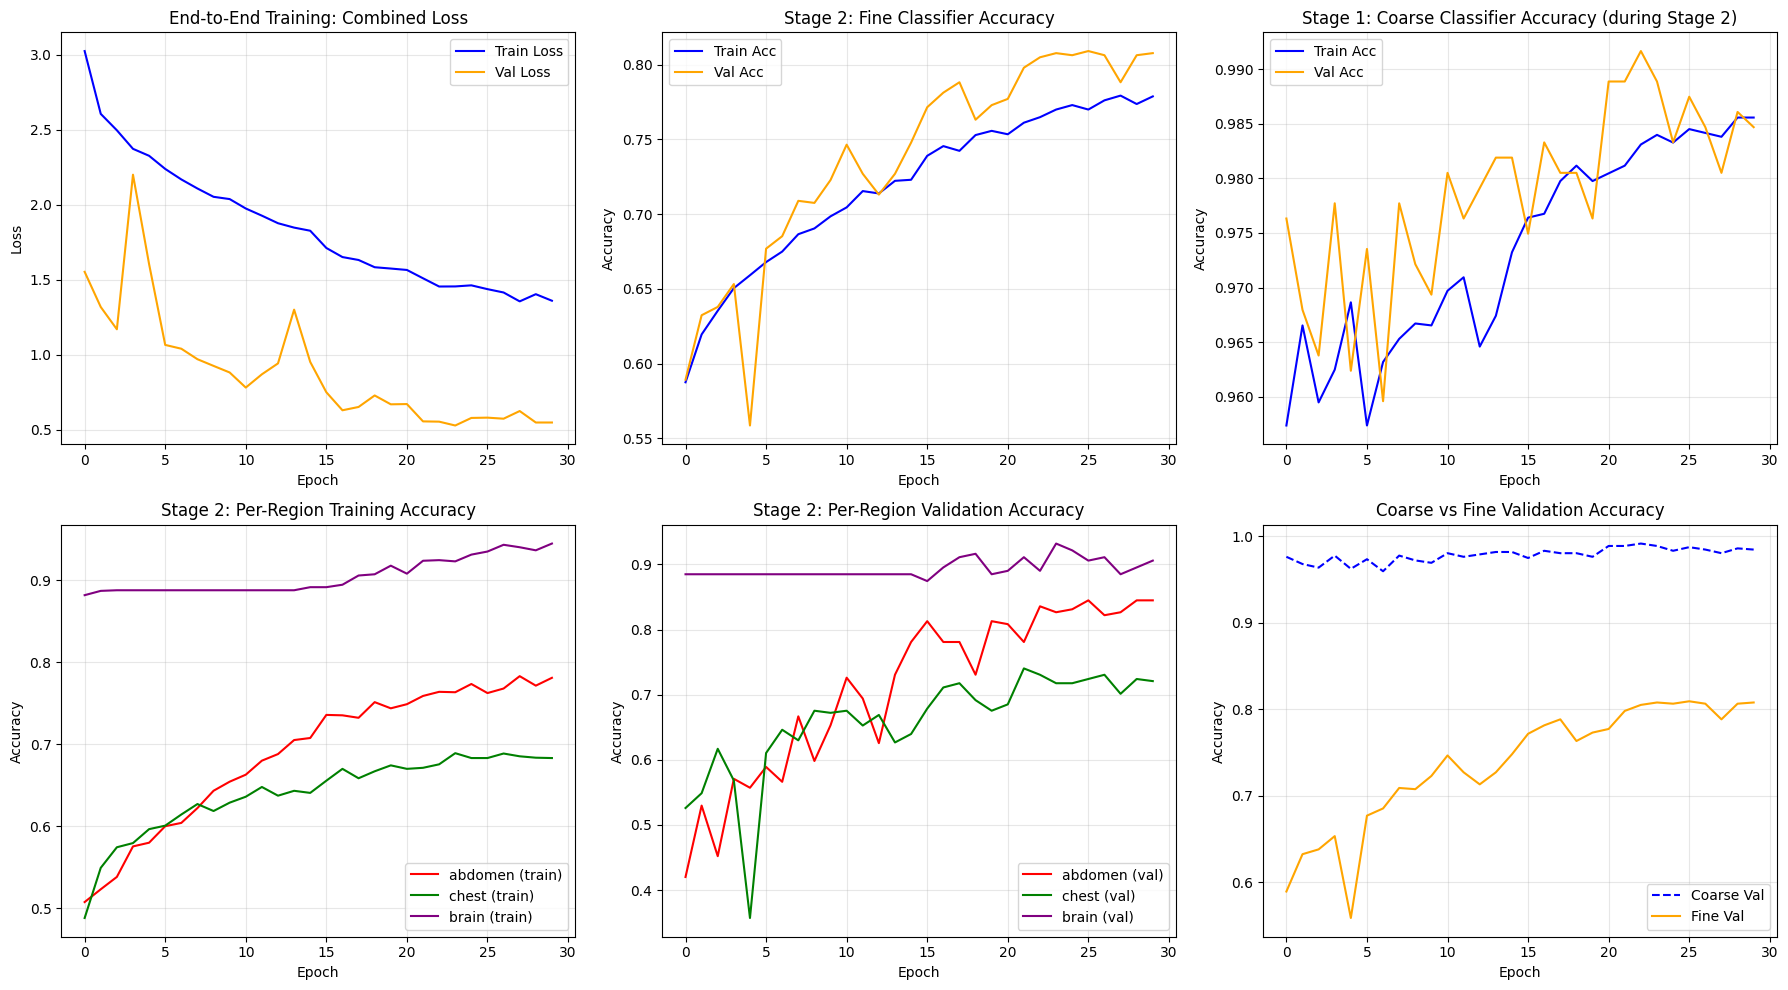

In [10]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Overall Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('End-to-End Training: Combined Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Overall Fine Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[0, 1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Stage 2: Fine Classifier Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Coarse Accuracy (Now also tracked during Stage 2!)
axes[0, 2].plot(history['coarse_train_acc'], label='Train Acc', color='blue')
axes[0, 2].plot(history['coarse_val_acc'], label='Val Acc', color='orange')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_title('Stage 1: Coarse Classifier Accuracy (during Stage 2)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Per-region training accuracy
colors = ['red', 'green', 'purple']
for i, (region_name, accs) in enumerate(history['region_train_acc'].items()):
    axes[1, 0].plot(accs, label=f'{region_name} (train)', color=colors[i % len(colors)])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Stage 2: Per-Region Training Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Per-region validation accuracy
for i, (region_name, accs) in enumerate(history['region_val_acc'].items()):
    axes[1, 1].plot(accs, label=f'{region_name} (val)', color=colors[i % len(colors)])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Stage 2: Per-Region Validation Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Combined comparison
axes[1, 2].plot(history['coarse_val_acc'], label='Coarse Val', color='blue', linestyle='--')
axes[1, 2].plot(history['val_acc'], label='Fine Val', color='orange', linestyle='-')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Coarse vs Fine Validation Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/stage2_fine_training_{MODEL_CONFIG['architecture']}.png", dpi=150)
plt.show()

## 6. Full Hierarchical Evaluation on Test Set

In [11]:
def evaluate_hierarchical_model(model, test_loader, device, region_idx_to_name):
    """Evaluate hierarchical model on test set."""
    model.eval()
    
    coarse_correct = 0
    coarse_total = 0
    
    fine_correct = {name: 0 for name in region_idx_to_name.values()}
    fine_total = {name: 0 for name in region_idx_to_name.values()}
    
    all_coarse_preds = []
    all_coarse_labels = []
    all_fine_preds = []
    all_fine_labels = []
    
    with torch.no_grad():
        for imgs, coarse_labels, fine_labels in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            coarse_labels = coarse_labels.long().to(device)
            fine_labels = fine_labels.long().to(device)
            
            # Stage 1: Coarse prediction
            coarse_logits = model.forward_coarse(imgs)
            coarse_preds = coarse_logits.argmax(1)
            
            coarse_correct += (coarse_preds == coarse_labels).sum().item()
            coarse_total += imgs.size(0)
            
            all_coarse_preds.extend(coarse_preds.cpu().numpy())
            all_coarse_labels.extend(coarse_labels.cpu().numpy())
            
            # Stage 2: Fine prediction per region
            for region_idx, region_name in region_idx_to_name.items():
                mask = (coarse_labels == region_idx)
                if not mask.any():
                    continue
                
                region_imgs = imgs[mask]
                region_fine_labels = fine_labels[mask]
                
                fine_logits = model.forward_fine(region_imgs, region_name)
                fine_preds = fine_logits.argmax(1)
                
                fine_correct[region_name] += (fine_preds == region_fine_labels).sum().item()
                fine_total[region_name] += region_imgs.size(0)
                
                all_fine_preds.extend(fine_preds.cpu().numpy())
                all_fine_labels.extend(region_fine_labels.cpu().numpy())
    
    # Compute metrics
    coarse_acc = coarse_correct / coarse_total if coarse_total > 0 else 0
    
    fine_acc_per_region = {}
    for region_name in region_idx_to_name.values():
        if fine_total[region_name] > 0:
            fine_acc_per_region[region_name] = fine_correct[region_name] / fine_total[region_name]
        else:
            fine_acc_per_region[region_name] = 0.0
    
    overall_fine_acc = sum(fine_correct.values()) / sum(fine_total.values()) if sum(fine_total.values()) > 0 else 0
    
    return {
        'coarse_accuracy': coarse_acc,
        'fine_accuracy_per_region': fine_acc_per_region,
        'overall_fine_accuracy': overall_fine_acc,
        'coarse_predictions': np.array(all_coarse_preds),
        'coarse_labels': np.array(all_coarse_labels),
        'fine_predictions': np.array(all_fine_preds),
        'fine_labels': np.array(all_fine_labels),
    }

In [12]:
# Load best model for evaluation
model.load_state_dict(torch.load(f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth"))

# Evaluate on test set
results = evaluate_hierarchical_model(model, test_loader, DEVICE, region_idx_to_name)

print("\n" + "="*60)
print("FULL HIERARCHICAL TEST RESULTS")
print("="*60)
print(f"\nStage 1 (Coarse) Accuracy: {results['coarse_accuracy']:.4f}")
print(f"\nStage 2 (Fine) Accuracy per Region:")
for region, acc in results['fine_accuracy_per_region'].items():
    print(f"  {region}: {acc:.4f}")
print(f"\nOverall Fine Accuracy: {results['overall_fine_accuracy']:.4f}")

/tmp/ipykernel_20387/1639041116.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['ar


FULL HIERARCHICAL TEST RESULTS

Stage 1 (Coarse) Accuracy: 0.9728

Stage 2 (Fine) Accuracy per Region:
  abdomen: 0.7965
  chest: 0.7412
  brain: 0.8691

Overall Fine Accuracy: 0.7918


## 7. Save Final Model Information

In [13]:
# Save final model info
final_info = {
    'model_path': f"{PATHS['models']}/hierarchical_model_{MODEL_CONFIG['architecture']}.pth",
    'architecture': MODEL_CONFIG['architecture'],
    'coarse_architecture': MODEL_CONFIG['coarse_architecture'],
    'fine_architecture': MODEL_CONFIG['fine_architecture'],
    'training_mode': 'end-to-end (no freezing)',
    'stage1_test_accuracy': stage1_info['test_accuracy'],
    'stage2_best_val_accuracy': best_val_acc,
    'coarse_test_accuracy': results['coarse_accuracy'],
    'fine_test_accuracy_per_region': results['fine_accuracy_per_region'],
    'overall_fine_test_accuracy': results['overall_fine_accuracy']
}

with open(f"{PATHS['models']}/hierarchical_model_info_{MODEL_CONFIG['architecture']}.json", 'w') as f:
    json.dump(final_info, f, indent=2)

print(f"\nFinal model info saved to: {PATHS['models']}/hierarchical_model_info_{MODEL_CONFIG['architecture']}.json")
print("\nHierarchical end-to-end training complete! You can now use the model for inference.")


Final model info saved to: /home/luca/HierarchicalMIC/models/hierarchical_model_info_enhanced.json

Hierarchical end-to-end training complete! You can now use the model for inference.
